In [29]:
import os
import sys
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

import torch
from torchvision import transforms

In [2]:
# Load the pre-trained model and image processor
backbone_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')

backbone_model.eval()

# If you have a GPU (optional but recommended)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
backbone_model = backbone_model.to(device)

Using cache found in C:\Users\citak/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\citak/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\citak/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\citak/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [38]:
print(backbone_model)

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [3]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

In [4]:
# Load an image
image = Image.open("sample_scene.jpg").convert("RGB")
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
image_tensor = image_tensor.to(device)

print(image_tensor.shape)

torch.Size([1, 3, 224, 224])


In [5]:
# Extract features
with torch.no_grad():
    features = backbone_model(image_tensor)

In [6]:
features.shape

torch.Size([1, 768])

In [27]:
# If you want to extract features from a batch of images
def extract_features(image_paths, model, transform, device):
    all_features = []
    all_images = []
    for img_path in image_paths:
        img = Image.open(img_path).convert('RGB')
        all_images.append(img)
        img_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = model(img_tensor)
        all_features.append(feat)
    return torch.cat(all_features, dim=0), all_images

In [36]:
images_list = ['sample_scene.jpg', 'sample_scene_city.jpg', 'sample_scene_city2.jpg', 'sample_scene_city3.jpg']
images_features, images = extract_features(images_list, backbone_model, transform, device)

Similarity Matrix:
─────────────────────────────────────
│ 1.0000 │ 0.1036 │ 0.1437 │ 0.0102 │ 
│ 0.1036 │ 1.0000 │ 0.2699 │ 0.3047 │ 
│ 0.1437 │ 0.2699 │ 1.0000 │ 0.3915 │ 
│ 0.0102 │ 0.3047 │ 0.3915 │ 1.0000 │ 
─────────────────────────────────────



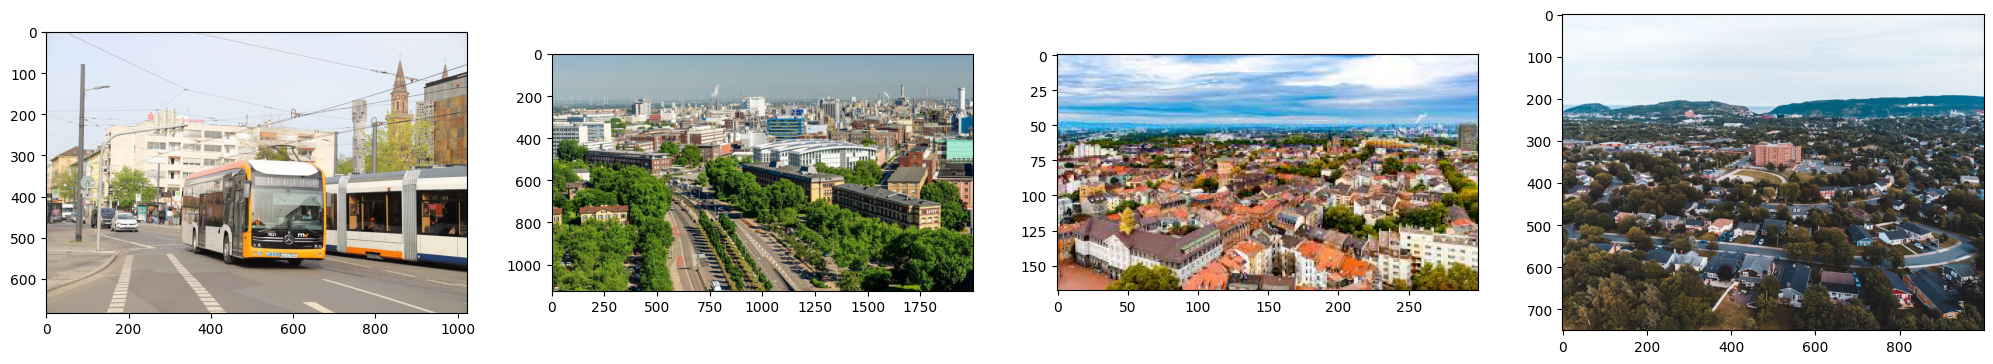

In [37]:
# Calculate similarity
similarity_matrix = np.zeros((4,4), dtype=np.float32)
for i in range(images_features.shape[0]):
    for j in range(images_features.shape[0]):
        feat1 = images_features[i].cpu().numpy().reshape(1, -1)
        feat2 = images_features[j].cpu().numpy().reshape(1, -1)

        similarity = cosine_similarity(feat1, feat2)[0][0]

        similarity_matrix[i][j] = similarity

print("Similarity Matrix:")
print("─" * 37)
for row in similarity_matrix:
    print("│", end=" ")
    for val in row:
        print(f"{val:.4f}", end=" │ ")
    print()
print("─" * 37)
print()

fig, axrr = plt.subplots(1,4, figsize=(25,15))
axrr[0].imshow(images[0]);
axrr[1].imshow(images[1]);
axrr[2].imshow(images[2]);
axrr[3].imshow(images[3]);